# Entrenamiento y evaluación de una red neuronal convolucional con el *Rock, Paper & Scissors Data Set*

Comenzamos realizando la carga del *Rock, Paper & Scissors Data Set* mediante la librería ``tensorflow_datasets``. Indicaremos mediante sus parámetros que queremos un split entrenamiento/test y que lo utilizaremos para un algoritmo de Deep Learning Supervisado.

Se puede observar como disponemos de imágenes de 300x300 píxeles con tres niveles de colog (RGB), de ahí que los datos estén dispuestos en "matrices" 300x300x3. Contamos con 2520 instancias de entrenamiento y 372 de testing.

Se puede plantear la problemática de si estos datos son suficientes para realizar un entrenamiento efectivo de nuestro algoritmo de Deep Learning. Si bien no mostramos todo el proceso en este cuaderno, se realizó un entrenamiento con los datos proporcionados y se produjeron dos casuísticas.

1.- Para redes convolucionales sencillas (dos capas convolucionales y pocos nodos por capa) se producía un claro *underfitting* pues no se superaba una *accuracy* del 40% en ninguno de los conjuntos.

2.- Para redes convolucionales más complejas, se producía un rápido *overfitting* dónde se alcanzaba una *accuracy* próxima al 100% en el conjunto de entrenamiento, y un rendimiento muy pobre en el conjunto de test.

Para solucionarlo, proponemos un procedimiento de aumentado artificial de la información que explicamos más adelante.

In [1]:
import pandas as pd
import numpy as np
import random, time
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#BATCH_SIZE = 32
(X_train, y_train), (X_test, y_test) = tfds.as_numpy(tfds.load('rock_paper_scissors', 
                                                    split = ['train', 'test'],
                                                    batch_size = -1,
                                                    as_supervised = True))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)                                             

c:\Users\kmart\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(2520, 300, 300, 3)
(2520,)
(372, 300, 300, 3)
(372,)


In [2]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [3]:
X_train

array([[[[0.99607843, 0.99607843, 0.99607843],
         [0.99215686, 0.99215686, 0.99215686],
         [0.99607843, 0.99607843, 0.99607843],
         ...,
         [0.98431373, 0.98431373, 0.98431373],
         [0.98039216, 0.98039216, 0.98039216],
         [0.98039216, 0.98039216, 0.98039216]],

        [[0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99215686, 0.99215686, 0.99215686],
         ...,
         [0.98039216, 0.98039216, 0.98039216],
         [0.98431373, 0.98431373, 0.98431373],
         [0.97647059, 0.97647059, 0.97647059]],

        [[0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         ...,
         [0.98431373, 0.98431373, 0.98431373],
         [0.98039216, 0.98039216, 0.98039216],
         [0.98823529, 0.98823529, 0.98823529]],

        ...,

        [[0.98823529, 0.98823529, 0.98823529],
         [0.98431373, 0.98431373, 0.98431373]

Procedemos con el aumentado de datas mediante la clase ``ImageDataGenerator``, esta clase permite tomar imágenes y realizar transformaciones en base a los parámetros que fijemos. En este caso, la clase realizará aleatoriamente las siguientes transformaciones sobre las imágenes del conjunto de datos:

1.- Desplazado horiziontal y vertical indicado en porcentaje de la imágen a desplazar (en nuestro caso 20% como máximo).

2.- Volteado horizontal de la imágen.

3.- Rotado de la imágen desde 0 a 360º. 

4.- Zoom sobre la imágen. En este caso, un 30% de zoom "hacia fuera" (zoom in) o "hacia dentro" (zoom out) sobre la imágen.

Mediante esta clase podremos generar un iterador sobre nuestro conjunto de datos que aplicará de forma aleatoria estas transformaciones. De esta forma, logramos un aumentado del número de instancias sobre las que realizar nuestro entrenamiento.

In [4]:
data_gen = ImageDataGenerator(
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            horizontal_flip = True,
                            rotation_range = 360,
                            zoom_range = 0.3
)

Seguidamente obtenemos el número de clases y el número de instancias por clase. Podemos observar como el dataset tiene 3 clases (piedra, papel o tijera representadas como 0, 1 o 2) y 840 instancias por clase (por lo que es un conjunto de datos equilibrado).

In [5]:
classes, n_instances = np.unique(y_train, return_counts = True)
print(classes)
print(n_instances)

[0 1 2]
[840 840 840]


Teniendo en cuenta que nuestra red tendrá una capa de salida con activación ``softmax`` debemos codificar nuestra variable objetivo como *one-hot* utilizando la función ``to_categorical`` de ``Keras``.

In [6]:
n_classes = classes.size

y_train_oh = to_categorical(y_train, n_classes)
y_test_oh = to_categorical(y_test, n_classes)

Una vez visto esto, procedemos a realizar el entrenamiento de nuestra red neuronal convolucional. Nuestra red tendrá la siguiente topología.

- Una capa convolucional ``Conv2D`` con 32 filtros, ventana de kernel 3x3 y activación ReLu.
- Seguida de una capa ``MaxPooling2D`` 2x2 que produce un *downsampling* de la salida generada por las capas convolucionales.
- Una capa ``Dropout`` con una tasa de puesta a 0 del 10% para evitar el *overfitting*.
- Esta estructura se repite 3 veces y finalmente conecta con una capa ``Flatten`` que funciona como capa de entrada de la red neuronal de salida. Esta capa tiene tantos nodos como características tienen nuestras instancias.
- Capa oculta ``Dense`` con 128 nodos y función de activación ReLu.
- Capa ``Dropout`` para paliar el *overfitting*.
- Capa de salida con función de activación ``softmax`` para obtener la probabilidad de pertenencia a cada clase.

De nuevo, utilizaremos la ``categorical_crossentropy`` como función de pérdida y el algoritmo de Adam como algoritmo de optimización de los pesos y parámetros de nuestra red. Como hemos explicado anteriormente, generaremos un iterador sobre el ``ImageDataGenerator`` para aplicar transformaciones al conjunto de entrada. Estas transformaciones se utilizarán durante el entrenamiento del modelo descrito. 

Debido a que este cuaderno se ejecutó en un sistema sin GPU compatible con ``TensorFlow``, únicamente computaremos 25 iteraciones del algoritmo, pues la demora es muy significativa. Puede observarse sin embargo en las gráficas de más abajo, que los resultados podrían mejorar si se hubiesen computado más iteraciones.

In [7]:
seed = random.seed(time.time())

model = keras.Sequential()
# Generamos la siguiente estructura de capas:
# 1.- Capa convolucional con 32 neuronas, tamaño de kernel 3x3, activación ReLU y regularizador L2 para evitar overfitting.
# 2.- Capa MaxPooling con tamaño 2x2 para realizar downsampling.
# 3.- Capa dropout con tasa del 0.3 para, de nuevo, tratar de evitar overfitting.
# Esta estructura se repite 3 veces de forma secuencial
model.add(Conv2D(32, kernel_size = (3, 3), input_shape = (300, 300, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.1, seed = seed))
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.1, seed = seed))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.1, seed = seed))
# Red neuronal de salida, su capa de entrada tendrá tantos nodos como características
# tenga cada instancia del problema. Para ello usamos Flatten(). 
model.add(Flatten())
# Capa oculta (densa) de la red neuronal de salida con 128 neuronas y activacion ReLu
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2, seed = seed))
# Capa de salida con activación softmax y tantos nodos como clases tenga el problema
# Esta capa nos devolverá la probabilidad de pertenencia a cada clase.
model.add(Dense(n_classes, activation = 'softmax'))

# Compilamos el modelo utilizando categorical_crossentropy como función de pérdida, optimización con algoritmo de Adam
# y accuracy como métrica del rendimiento.
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# Creamos el iterador de data_gen
iterator = data_gen.flow(X_train, y_train_oh)
history = model.fit_generator(iterator, 
                            validation_data = (X_test, y_test_oh), 
                            epochs = 25)
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

model_history

C:\Users\kmart\AppData\Local\Temp\ipykernel_3036\3986678955.py:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(iterator,


Epoch 1/25
79/79 [==============================] - 139s 2s/step - loss: 1.4963 - accuracy: 0.3512 - val_loss: 1.0985 - val_accuracy: 0.3387
Epoch 2/25
79/79 [==============================] - 128s 2s/step - loss: 1.0833 - accuracy: 0.3857 - val_loss: 1.0382 - val_accuracy: 0.5403
Epoch 3/25
79/79 [==============================] - 130s 2s/step - loss: 1.0349 - accuracy: 0.4433 - val_loss: 0.9387 - val_accuracy: 0.6156
Epoch 4/25
79/79 [==============================] - 122s 2s/step - loss: 0.9590 - accuracy: 0.5044 - val_loss: 0.8234 - val_accuracy: 0.6290
Epoch 5/25
79/79 [==============================] - 123s 2s/step - loss: 0.8515 - accuracy: 0.5889 - val_loss: 0.6948 - val_accuracy: 0.6694
Epoch 6/25
79/79 [==============================] - 122s 2s/step - loss: 0.7925 - accuracy: 0.6028 - val_loss: 0.7522 - val_accuracy: 0.6478
Epoch 7/25
79/79 [==============================] - 122s 2s/step - loss: 0.7236 - accuracy: 0.6643 - val_loss: 0.5853 - val_accuracy: 0.7742
Epoch 8/25
79

,loss,accuracy,val_loss,val_accuracy,epoch
0,1.496301,0.351190,1.098493,0.338710,0
1,1.083251,0.385714,1.038177,0.540323,1
2,1.034949,0.443254,0.938724,0.615591,2
3,0.958997,0.504365,0.823419,0.629032,3
4,0.851455,0.588889,0.694788,0.669355,4
5,0.792544,0.602778,0.752246,0.647849,5
6,0.723571,0.664286,0.585326,0.774194,6
7,0.647659,0.703571,0.562306,0.712366,7
8,0.572234,0.755556,0.376929,0.852151,8
9,0.535541,0.762698,0.557764,0.720430,9


De estos resultados, vemos como se alcanza una precisión del ~90% para el conjunto de training, y una precisión que oscila entre el 85% y el 95% en el conjunto de test. Se observa una tendencia creciente en la precisión del conjunto de entrenamiento, por lo que es posible que los resultados mejorasen en caso de computarse más iteraciones.

Procedemos a obtener la predicción de nuestro modelo sobre los datos de test y la obtención de la matriz de confusión.

In [8]:
y_pred = model.predict(X_test)
class_pred = y_pred.argmax(axis = 1)
print(class_pred)

12/12 [==============================] - 5s 295ms/step
[2 1 0 0 0 0 1 1 2 0 2 2 0 0 0 2 0 2 0 1 1 0 0 1 2 2 0 0 2 0 2 0 1 2 0 0 1
 0 2 2 0 1 0 1 1 2 2 1 0 2 0 2 0 1 0 1 1 2 2 1 1 2 0 2 0 1 1 0 2 1 0 2 0 1
 1 0 2 0 0 1 0 2 2 1 2 0 0 1 2 0 2 2 2 0 0 1 1 2 0 2 0 1 0 0 0 0 2 1 1 2 0
 2 1 1 0 2 1 1 0 1 0 0 0 2 2 0 0 2 1 0 1 1 0 1 2 1 1 0 2 0 1 0 0 2 0 0 0 0
 1 1 1 0 2 1 1 2 0 0 2 1 1 0 0 0 2 2 0 1 2 2 0 2 2 0 0 0 2 0 2 0 2 1 0 1 2
 2 2 0 1 1 2 2 2 1 1 0 1 2 0 1 2 1 0 2 1 1 1 0 0 1 0 0 0 0 2 1 2 1 1 0 2 2
 0 2 0 0 0 0 0 0 0 0 1 2 1 0 0 1 1 2 2 2 1 2 0 0 1 2 0 0 0 2 2 0 1 2 1 0 1
 2 0 0 2 2 0 2 1 0 1 0 1 0 0 2 0 2 0 0 2 1 0 2 2 1 0 1 2 1 2 0 2 1 0 0 1 1
 0 1 0 2 0 1 1 2 0 0 0 2 1 0 1 2 0 0 0 2 2 0 0 1 0 0 0 2 1 0 2 2 2 1 2 2 1
 1 0 2 1 0 2 2 0 2 1 0 0 0 1 2 2 0 0 2 2 2 0 2 2 0 2 1 1 1 0 1 2 0 0 0 1 0
 1 1]


Para obtener la matriz de confusión, utilizaremos la función ``confusion_matrix`` del módulo ``math`` de ``TensorFlow``. De los resultados, puede observarse como obtenemos el mayor número de aciertos (true positives, valores de la diagonal) para las clases 0 y 2. Sin embargo, para la clase 1 parece generar un mayor número de confusiones (105 aciertos frente a 19 fallos), lo que supone la principal fuente de pérdida de precisión en nuestras predicciones.

In [9]:
tf.math.confusion_matrix(y_test, class_pred)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[124,   0,   0],
       [ 15, 105,   4],
       [ 13,   0, 111]])>

In [10]:
# Obtenemos la exactitud tanto en el conjunto de entrenamiento como en el de test
_, train_acc = model.evaluate(X_train, y_train_oh, verbose = 0)
_, test_acc = model.evaluate(X_test, y_test_oh, verbose = 0)

print(f'Accuracy en conjunto de entrenamiento -> {train_acc}')
print(f'Accuracy en conjunto de test -> {test_acc}')

Accuracy en conjunto de entrenamiento -> 0.9611111283302307
Accuracy en conjunto de test -> 0.9139785170555115


Si realizamos un plot de la evolución de la *acurracy* del conjunto de test y entrenamiento frente al número de iteraciones, podemos observar dos tendencias.

1.- El conjunto de entrenamiento presenta una tendencia claramente ascendente que podría mejorar a mayor número de iteraciones.

2.- En el conjunto de test la precisión parece oscilar alrededor del 70-90% en las últimas iteraciones del modelo. Esto puede llevarnos a pensar que se necesitan más iteraciones para lograr un mejor ajuste o quizá una selección distinta de la topología y/o hiperparámetros del modelo.

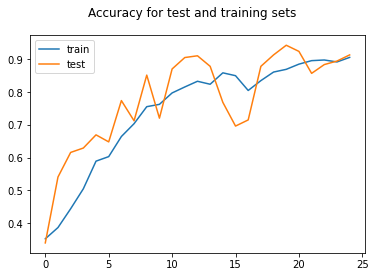

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.suptitle('Accuracy for test and training sets')
plt.plot(model_history['accuracy'], label = 'train')
plt.plot(model_history['val_accuracy'], label = 'test')
plt.legend()
plt.show()